# NYC Motor Vehicle Collision Analysis

This notebook serves as a report for collision data from the NYC Open Data API, including crashes, vehicles, and persons involved.

**Data Sources:**
- Crashes: Basic collision information
- Vehicles: Detailed vehicle and driver data
- Persons: Individual-level injury and safety data

### Feel free to do some or all of the prompts listed below. We would love to see some data visualizations as well as tables

**We are more interested in what data you display and how you decide to display the data**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load environment and connect to database
load_dotenv()
POSTGRES_URL = os.getenv('POSTGRES_URL')
if not POSTGRES_URL:
    raise RuntimeError('POSTGRES_URL not set in .env')

engine = create_engine(POSTGRES_URL)
print('✅ Connected to PostgreSQL!')

def q(sql, **params):
    return pd.read_sql(text(sql), engine, params=params)

✅ Connected to PostgreSQL!


## 1. Overview - Collision Summary

total number of collisions, injuries, and fatalities for 2024 in NYC



In [4]:
import pandas as pd

overview = pd.read_sql("""
SELECT
  total_collisions,
  injury_incidents,
  fatal_incidents,
  total_persons_injured,
  total_persons_killed
FROM analytics.collision_summary;
""", engine)

overview

,total_collisions,injury_incidents,fatal_incidents,total_persons_injured,total_persons_killed
0,91315,40040,252,54029,268


## 2. Geographic Analysis - Collisions by Borough

Incident summary by Borough 

In [6]:
borough_df = pd.read_sql("""
select
  borough,
  count(*) as collisions,
  sum(persons_injured) as persons_injured,
  sum(persons_killed) as persons_killed,
  sum(is_injury) as injury_crashes,
  sum(is_fatal) as fatal_crashes
from analytics.fact_crashes
where borough is not null
  and crash_date >= date '2024-01-01'
  and crash_date < date '2025-01-01'
group by borough
order by collisions desc;
""", engine)

borough_df

,borough,collisions,persons_injured,persons_killed,injury_crashes,fatal_crashes
0,BROOKLYN,22785,13152,53,9994,53
1,QUEENS,17812,9940,31,7633,31
2,MANHATTAN,11903,5778,32,4875,28
3,BRONX,10033,6026,33,4417,29
4,STATEN ISLAND,2697,1303,11,985,11


## 3. Temporal Patterns - When Do Collisions Happen?

Are there days or times where incidents happen more frequently 

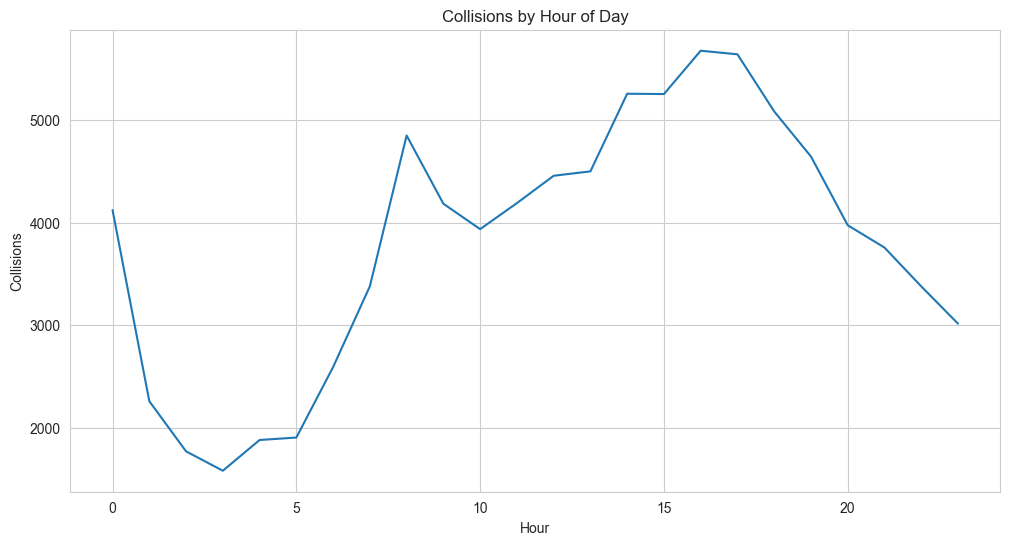

In [9]:
hour_df = pd.read_sql("""
select
  crash_hour,
  count(*) as collisions
from analytics.fact_crashes
where crash_hour is not null
group by crash_hour
order by crash_hour;
""", engine)

sns.lineplot(data=hour_df, x="crash_hour", y="collisions")
plt.title("Collisions by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Collisions")
plt.show()

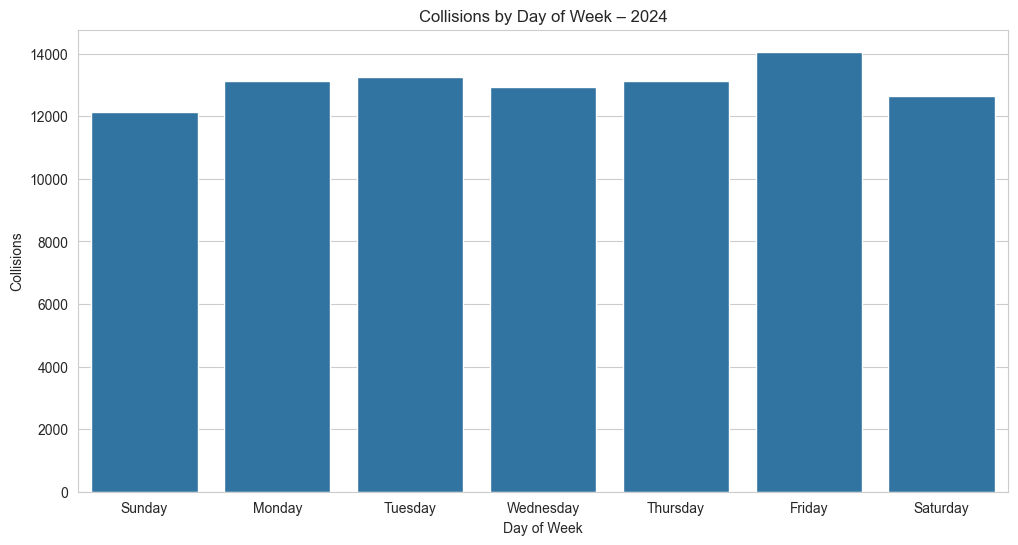

In [11]:
# Map day numbers to names
dow_map = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

dow_df["day_name"] = dow_df["crash_dow"].map(dow_map)

# Ensure correct order
dow_df["day_name"] = pd.Categorical(
    dow_df["day_name"],
    categories=[
        "Sunday", "Monday", "Tuesday",
        "Wednesday", "Thursday", "Friday", "Saturday"
    ],
    ordered=True
)

dow_df = dow_df.sort_values("day_name")

sns.barplot(data=dow_df, x="day_name", y="collisions")
plt.title("Collisions by Day of Week – 2024")
plt.xlabel("Day of Week")
plt.ylabel("Collisions")
plt.show()

## 5. Vehicle Analysis - Vehicle Types and Safety

What vehicle types are more than likely to be in a crash and are there vehicles safer than others?

In [14]:
vehicle_df = pd.read_sql("""
select
  vehicle_type,
  count(*) as crashes
from raw.collision_vehicles
where vehicle_type is not null
group by vehicle_type
order by crashes desc
limit 10;
""", engine)

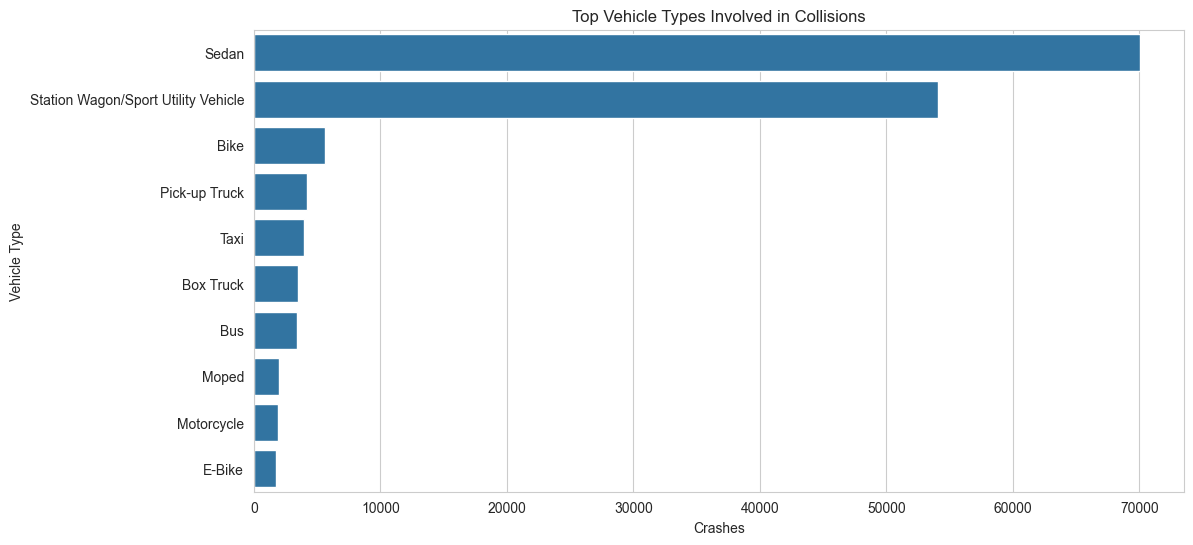

In [15]:
sns.barplot(data=vehicle_df, x="crashes", y="vehicle_type")
plt.title("Top Vehicle Types Involved in Collisions")
plt.xlabel("Crashes")
plt.ylabel("Vehicle Type")
plt.show()

## 8. Contributing Factors - What Causes Collisions?

In [17]:
factor_df = pd.read_sql("""
select
  contributing_factor_vehicle_1 as factor,
  count(*) as crashes
from analytics.fact_crashes
where contributing_factor_vehicle_1 is not null
group by factor
order by crashes desc
limit 10;
""", engine)

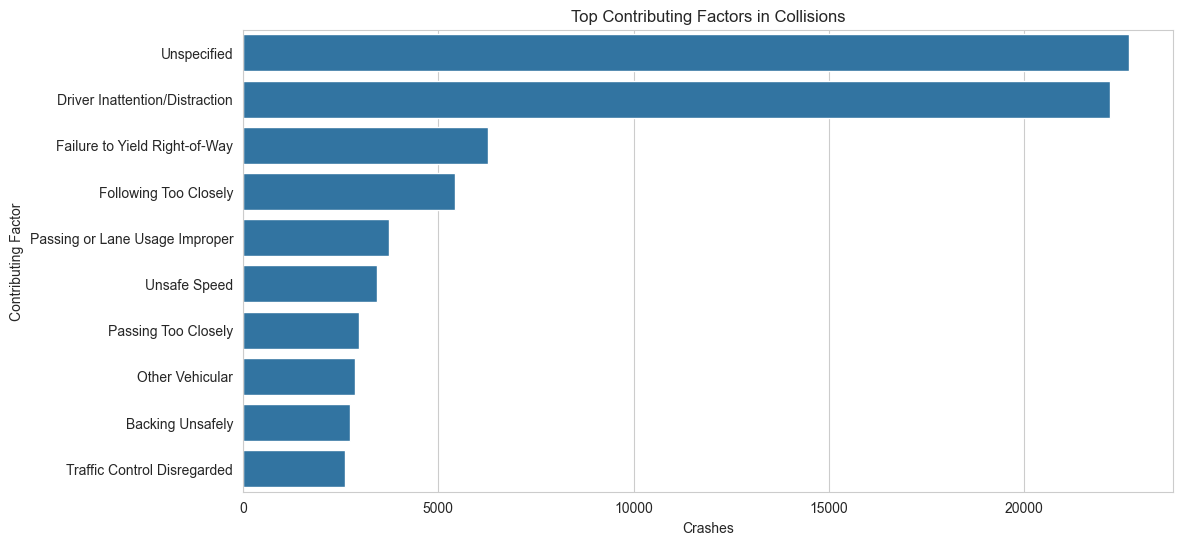

In [18]:
sns.barplot(data=factor_df, x="crashes", y="factor")
plt.title("Top Contributing Factors in Collisions")
plt.xlabel("Crashes")
plt.ylabel("Contributing Factor")
plt.show()